## __Importando bibliotecas necessárias__

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tfw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import shutil

## __Defina o caminho para as pastas__

In [25]:
pathO = os.getcwd()
path = pathO + "\\produtos_regionais\\"
log_dir = pathO + "\\logs"
output_dir = pathO + "\\models\\"

## __Criar pasta de Logs__

In [26]:
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)  # Remove a pasta e todo o conteúdo
    print(f"Pasta existente removida: {log_dir}")

os.makedirs(log_dir)
print(f"Pasta criada: {log_dir}")

Pasta existente removida: C:\Users\PC\Documents\GitHub\treinandoEficcientNet2\logs
Pasta criada: C:\Users\PC\Documents\GitHub\treinandoEficcientNet2\logs


## __Criar o callback do TensorBoard__

In [27]:
tensorboard_callback = TensorBoard(log_dir=log_dir)

## __Configurações de Data Augmentation__

In [28]:
datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=20,
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,    
    fill_mode='nearest'     
)

## __Gerando os dados de treino__

In [6]:
train_generator = datagen.flow_from_directory(
    directory=path + 'train',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

Found 272 images belonging to 4 classes.


## __Gerando os dados de validação__

In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=path + 'val',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

Found 64 images belonging to 4 classes.


## __Gerando os dados de teste__

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apenas normalização, sem augmentação

test_generator = test_datagen.flow_from_directory(
    directory=path + 'test',  # Substitua pelo caminho do diretório de teste
    target_size=(224, 224),          # Redimensiona as imagens para 224x224 pixels
    batch_size=32,                   # Tamanho do lote
    class_mode='categorical',
    shuffle=True
)

Found 124 images belonging to 4 classes.


## __Definindo hiperparâmetros__

In [9]:
epochs = 30
batch_size = 16
learning_rate = 0.0001
optimizer = Adam

## __Treinando modelo__

In [10]:
results = []
cont=1
try:
    # Configurando os geradores de dados
    train_generator.batch_size = batch_size
    validation_generator.batch_size = batch_size
    

    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    
    # Congelar as camadas iniciais para não treinar novamente
    for layer in base_model.layers[-5:]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(len(train_generator.class_indices), 
                    activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compilando o modelo
    model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Treinando o modelo
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[tensorboard_callback]
    )
    # Avaliando o modelo
    final_loss, final_accuracy = model.evaluate(validation_generator)
    best_model = model
    results.append({
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'optimizer': optimizer.__name__,
        'final_loss': final_loss,
        'final_accuracy': final_accuracy,
        'loss': history.history['loss'][-1],  # A última perda de treino
        'accuracy': history.history['accuracy'][-1],  # A última acurácia de treino
        'val_loss': history.history['val_loss'][-1],  # A última perda de validação
        'val_accuracy': history.history['val_accuracy'][-1],  # A última acurácia de validação
        'history': history  # Armazenando o histórico completo
    })
    cont+=1
except Exception as e:
    print(f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer} {e}")

Epoch 1/30
17/17 [==============================] - 45s 2s/step - loss: 1.2033 - accuracy: 0.5294 - val_loss: 1.3913 - val_accuracy: 0.2500
Epoch 2/30
17/17 [==============================] - 64s 4s/step - loss: 0.6782 - accuracy: 0.9154 - val_loss: 1.4079 - val_accuracy: 0.2031
Epoch 3/30
17/17 [==============================] - 47s 3s/step - loss: 0.2858 - accuracy: 0.9559 - val_loss: 1.2889 - val_accuracy: 0.3125
Epoch 4/30
17/17 [==============================] - 41s 2s/step - loss: 0.1238 - accuracy: 0.9779 - val_loss: 1.2793 - val_accuracy: 0.3281
Epoch 5/30
17/17 [==============================] - 33s 2s/step - loss: 0.0666 - accuracy: 0.9853 - val_loss: 0.9419 - val_accuracy: 0.6094
Epoch 6/30
17/17 [==============================] - 83s 5s/step - loss: 0.0403 - accuracy: 0.9926 - val_loss: 0.7962 - val_accuracy: 0.7500
Epoch 7/30
17/17 [==============================] - 37s 2s/step - loss: 0.0429 - accuracy: 0.9926 - val_loss: 0.2349 - val_accuracy: 0.9688
Epoch 8/30
17/17 [==

## __Convertendo resultados em DataFrame__

In [11]:
results_df = pd.DataFrame(results)
folder_path=pathO+"\\resultados\\"
csv_file_path = os.path.join(folder_path, 'results_shuffletest.csv')
results_df.to_csv(csv_file_path, index=False)
print(results_df)

   epochs  batch_size  learning_rate optimizer  final_loss  final_accuracy  \
0      30          16         0.0001      Adam    0.051598             1.0   

       loss  accuracy  val_loss  val_accuracy  \
0  0.002132       1.0  0.051598           1.0   

                                             history  
0  <keras.callbacks.History object at 0x000001EB6...  


## __Salvar o modelo__

In [12]:
model_name = f"individual_model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer.__name__}_shuffle.h5"
best_model.save(os.path.join(output_dir, model_name), save_format='h5')

## __Encontrar o melhor modelo com base na acurácia de validação__

In [13]:
best_accuracy = 0
best_history = None

# Iterar sobre os resultados para encontrar o modelo com a maior val_accuracy
for result in results:
    val_accuracy = result.get('val_accuracy', 0)  # Obtém a acurácia de validação
    
    # Verifica se a acurácia de validação é maior que a atual
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_history = result  # Armazena o histórico do melhor modelo

## __Gerar gráfico do melhor modelo__

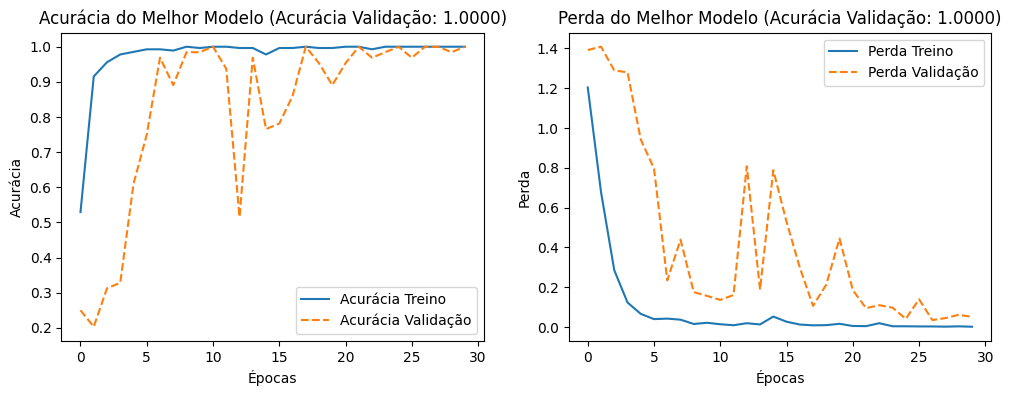

In [14]:
if best_history:
    plt.figure(figsize=(12, 4))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(best_history['history'].history['accuracy'], label='Acurácia Treino')
    plt.plot(best_history['history'].history['val_accuracy'], label='Acurácia Validação', linestyle='--')
    plt.title(f"Acurácia do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(best_history['history'].history['loss'], label='Perda Treino')
    plt.plot(best_history['history'].history['val_loss'], label='Perda Validação', linestyle='--')
    plt.title(f"Perda do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Exibindo os gráficos
    plt.show()
else:
    print("Nenhum modelo foi encontrado.")

## __Gerando a matriz de confusão para o melhor modelo__

In [15]:
y_true = validation_generator.classes
y_pred = best_model.predict(validation_generator)  # Não precisa de ['model'], apenas use o objeto diretamente
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 [==============================] - 6s 1s/step


## __Criando a matriz de confusão__

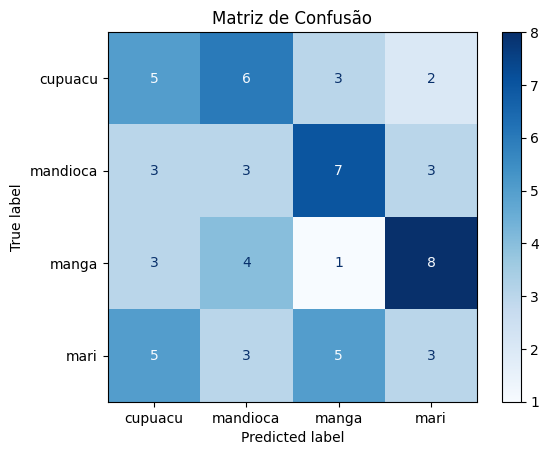

In [16]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## __Avaliação do modelo com o conjunto de teste__

In [17]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Loss no conjunto de teste: {test_loss}")
print(f"Acurácia no conjunto de teste: {test_accuracy}")

4/4 [==============================] - 10s 3s/step - loss: 0.0870 - accuracy: 0.9597
Loss no conjunto de teste: 0.08704448491334915
Acurácia no conjunto de teste: 0.9596773982048035


## __Função de Predição__

In [18]:
def predict_image_class(image_path, model, class_indices):
    # Carregar a imagem
    img = load_img(image_path, target_size=(224, 224))  # Redimensiona para o tamanho usado no modelo
    img_array = img_to_array(img)  # Converte para array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para lote
    img_array = img_array / 255.0  # Normaliza os valores para o intervalo [0, 1]

    # Previsão
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]  # Índice da classe com maior probabilidade

    # Mapeando índice para a classe
    class_labels = {v: k for k, v in class_indices.items()}  # Inverte o mapeamento
    predicted_class = class_labels[predicted_class_idx]

    return predicted_class

## __Exemplo de Previsão__

In [22]:
image_path = pathO + "\\to_predict\\cupuacu.jpg"
predicted_class = predict_image_class(image_path, best_model, train_generator.class_indices)
print(f"A imagem pertence à classe: {predicted_class}")

1/1 [==============================] - 0s 53ms/step
A imagem pertence à classe: mandioca


## __Finalizando o TensorBoard__

In [23]:
%load_ext tensorboard
%tensorboard --logdir .\logs

Reusing TensorBoard on port 6006 (pid 18084), started 2 days, 5:48:23 ago. (Use '!kill 18084' to kill it.)

In [51]:
!taskkill /IM tensorboard.exe /F

ERRO: o processo "tensorboard.exe" nÆo foi encontrado.


In [53]:
%reload_ext tensorboard